In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import json
import sys

sys.path.append(os.path.join(os.getcwd(), os.pardir, os.pardir))

from Tools.load_save_utils import load_acquisition_reconstruction_from_nii, load_model_weights
from Tools.reconstruction_utils import NN_prediction, NN_prediction_complex
from Plot.plot_utils import plot_parameter_maps
from Neural_Networks.networks import initialize_network

2025-06-17 00:41:43.661565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-17 00:41:43.682872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-17 00:41:43.689149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 00:41:43.706086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 00:41:44.600168: W tensorflow/compiler/tf2

In [3]:
path_to_summer = '/data_network/summer_projects/cungel/Current/'

In [31]:
roi_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/ROI_data/MAPIRMAGE_MRFUSE240620-all-ROI-2Dbrain_20240620-102756068.nii')
t1w_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_cs_3D_BrainVIEW_T1W_20240620-100542904.nii')
# Path 6 / 13 shots
spiral_6_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_bSSFP_ismrm_2D_6sur13_20240620-100542694.nii')
spiral_6_P_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_bSSFP_ismrm_2D_6sur13_P_20240620-100542758.nii')

# Path 10 / 13 shots
spiral_10_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_bSSFP_ismrm_2D_d3_10sur13_20240620-100542785.nii')
spiral_10_P_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_bSSFP_ismrm_2D_d3_10sur13_P_20240620-100542813.nii')

# Path 12 / 13 shots
spiral_12_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_bSSFP_ismrm_2D_d3_12sur13_20240620-100542838.nii')
spiral_12_P_path = os.path.join(path_to_summer,'2021_MRF_TC/MP3_projects/MP3_MRFUSE_20240620/Raw_data/MAPIRMAGE_MRFUSE240620-all-WIP_bSSFP_ismrm_2D_d3_12sur13_P_20240620-100542862.nii')

In [41]:
ROI_brain_map = load_acquisition_reconstruction_from_nii(roi_path, nb_indents=1, v=False)[0].astype(np.bool_)
ROI_brain_map = np.rot90(ROI_brain_map)

if ROI_brain_map.ndim == 2:
    ROI_brain_map = ROI_brain_map[:, :, None]

In [32]:
spiral_6 = nib.load(spiral_6_path).get_fdata()*np.exp(1j * nib.load(spiral_6_P_path).get_fdata())
spiral_10 = nib.load(spiral_10_path).get_fdata()*np.exp(1j * nib.load(spiral_10_P_path).get_fdata())
spiral_12 = nib.load(spiral_12_path).get_fdata()*np.exp(1j * nib.load(spiral_12_P_path).get_fdata())

# MARVEL magnitude

In [34]:
training_path = os.path.join(path_to_summer, '2023_MRF_Collab/Lila/MARVEL_training/DICO8/train_updated_code_v2_LR0.9')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [ ]:
n_epochs = 87
n_pulses = 260
# INITIALIZE NETWORK

print("\nINITIALIZE NETWORK")
NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)

#network_name = NETWORK_INFOS["network_name"]
network_name = "BiLSTM"
input_size = n_pulses #+ (layer_B1_constraint_incorporation == 0)
print(input_size)
layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))

NN.summary()


INITIALIZE NETWORK
260


/home/cungel/data_ssd/venv/venv_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 260, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         7,575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         3,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,481 (126.88 KB)

 Trainable params: 32,481 (126.88 KB)

 Non-trainable params: 0 (0.00 B)

/data_local/data_hdd/cungel/tmp/ipykernel_118345/1060109753.py:7: RuntimeWarning: invalid value encountered in divide
  RECO_mask_normalized = RECO / np.linalg.norm(RECO, axis=3)[:, :, :, None]


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


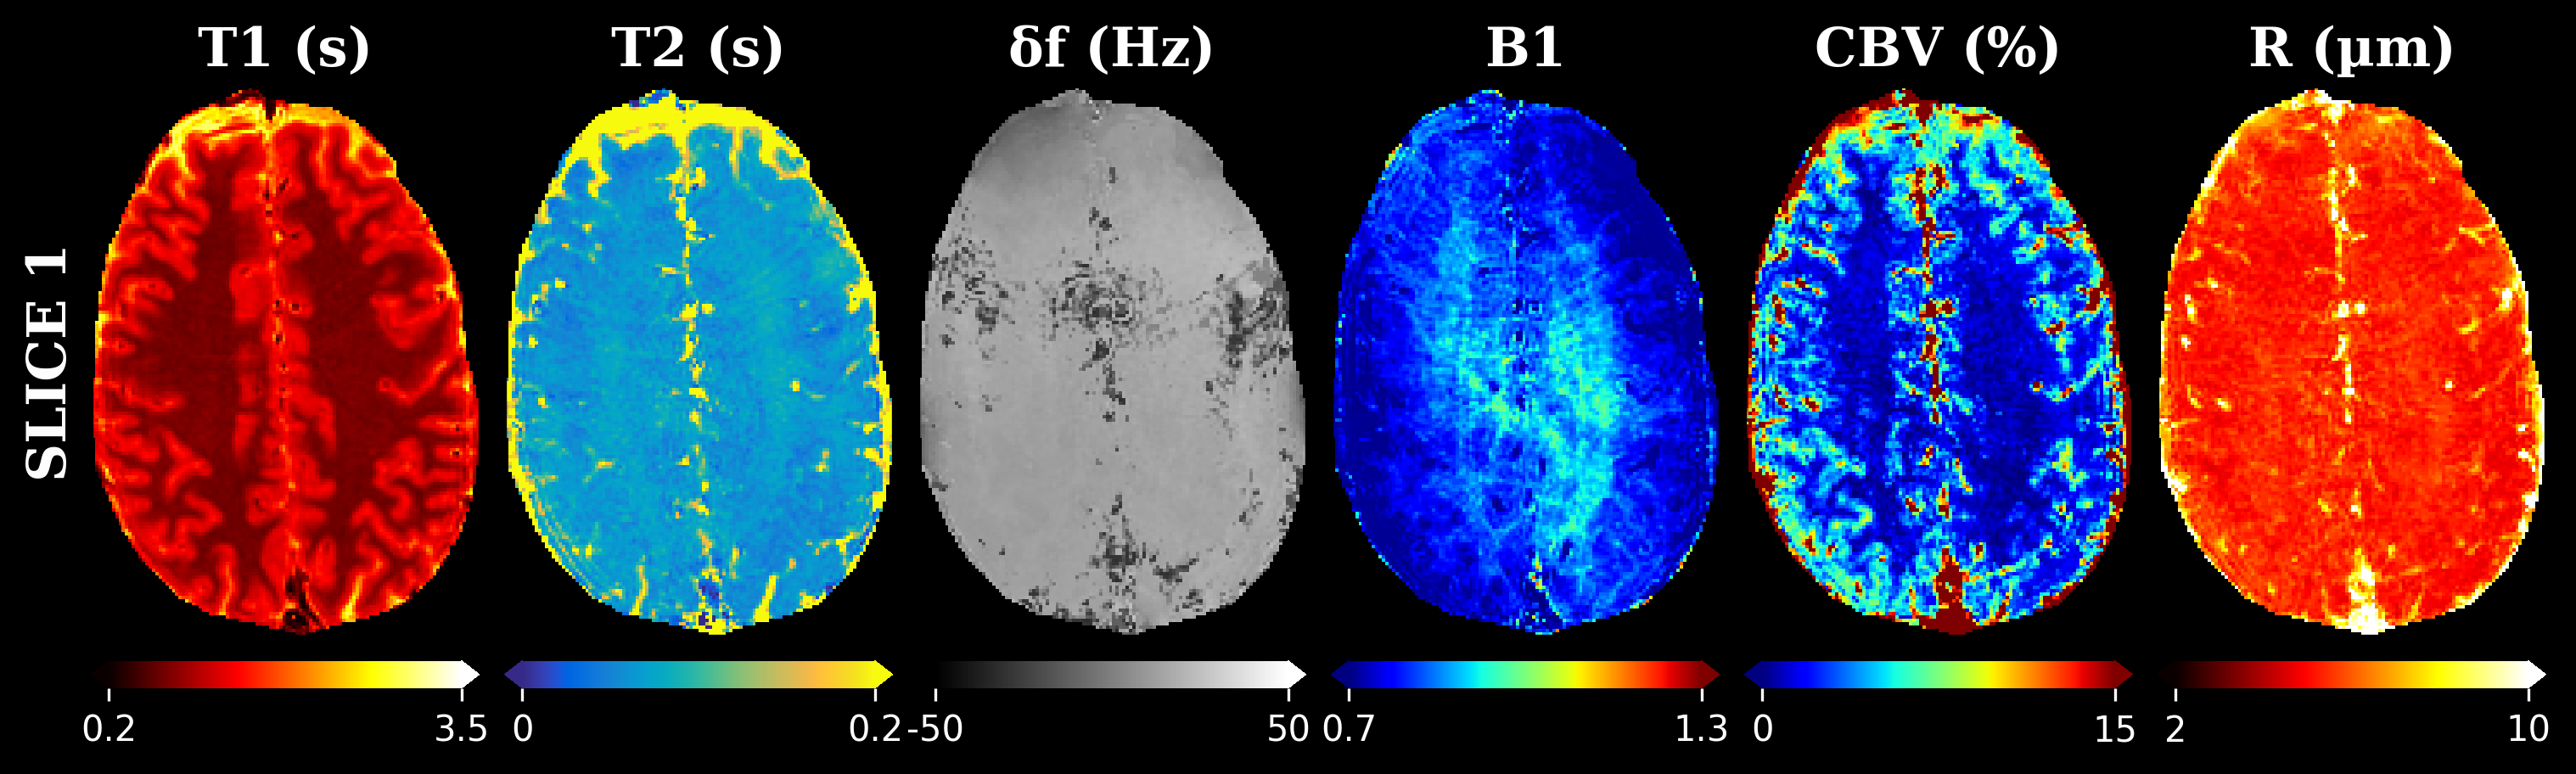

In [48]:
label_parameters = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']

RECO = np.abs(spiral_12)

RECO = np.rot90(RECO, 1)

RECO_mask_normalized = RECO / np.linalg.norm(RECO, axis=3)[:, :, :, None]

NN_reconstruction = NN_prediction(NN, RECO_mask_normalized, label_parameters, ROI_brain_map,  batch_size=1024)

fig = plot_parameter_maps(NN_reconstruction, label_parameters, crop_type='separate', title='', path_to_data=training_path, file_name='{}_{}epochs'.format('reco_CS5', n_epochs))
plt.savefig(os.path.join(path_to_summer, '2023_MRF_Collab/Lila/Prospective_study/MARVEL_spiral_12.png'))

# MARVEL complex

In [ ]:
path_to_summer_current = "/data_network/summer_projects/cungel/Current"

n_epochs = 53
training_path = os.path.join(path_to_summer_current, '2023_MRF_Collab/Lila/MARVEL_training/COMPLEX/training_from_magn_noise_phase')

RECOS_INFOS = json.load(open(os.path.join(training_path, 'training_infos.json')))

In [ ]:
n_pulses = 260

NETWORK_INFOS = RECOS_INFOS["NETWORK_INFOS"]
learned_labels = ['T1', 'T2', 'df', 'B1rel', 'Vf', 'R']
n_parameters = len(learned_labels)
layer_B1_constraint_incorporation = NETWORK_INFOS.get("incorporate_B1_constraint", False)

network_name = "BiLSTM_complex"
input_size = n_pulses #+ (layer_B1_constraint_incorporation == 0)

layer_shapes = [input_size] + NETWORK_INFOS["hidden_layer_shapes"] + [n_parameters]
activations = NETWORK_INFOS["activations"]

NN = initialize_network(network_name, layer_shapes, activations, layer_B1_constraint_incorporation)

load_model_weights(NN, layer_shapes, adding_text='_{}epochs'.format(n_epochs), path_to_model=os.path.join(training_path, 'weights'))


In [ ]:
RECO = spiral_12
RECO = np.rot90(RECO,1)
RECO = np.nan_to_num(RECO, nan=0.0, posinf=0.0, neginf=0.0)

norm_RECO = np.linalg.norm(RECO, axis=3, keepdims=True)
norm_RECO_safe = np.maximum(norm_RECO, 1e-8)

RECO_mask_normalized = RECO / norm_RECO_safe

252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step


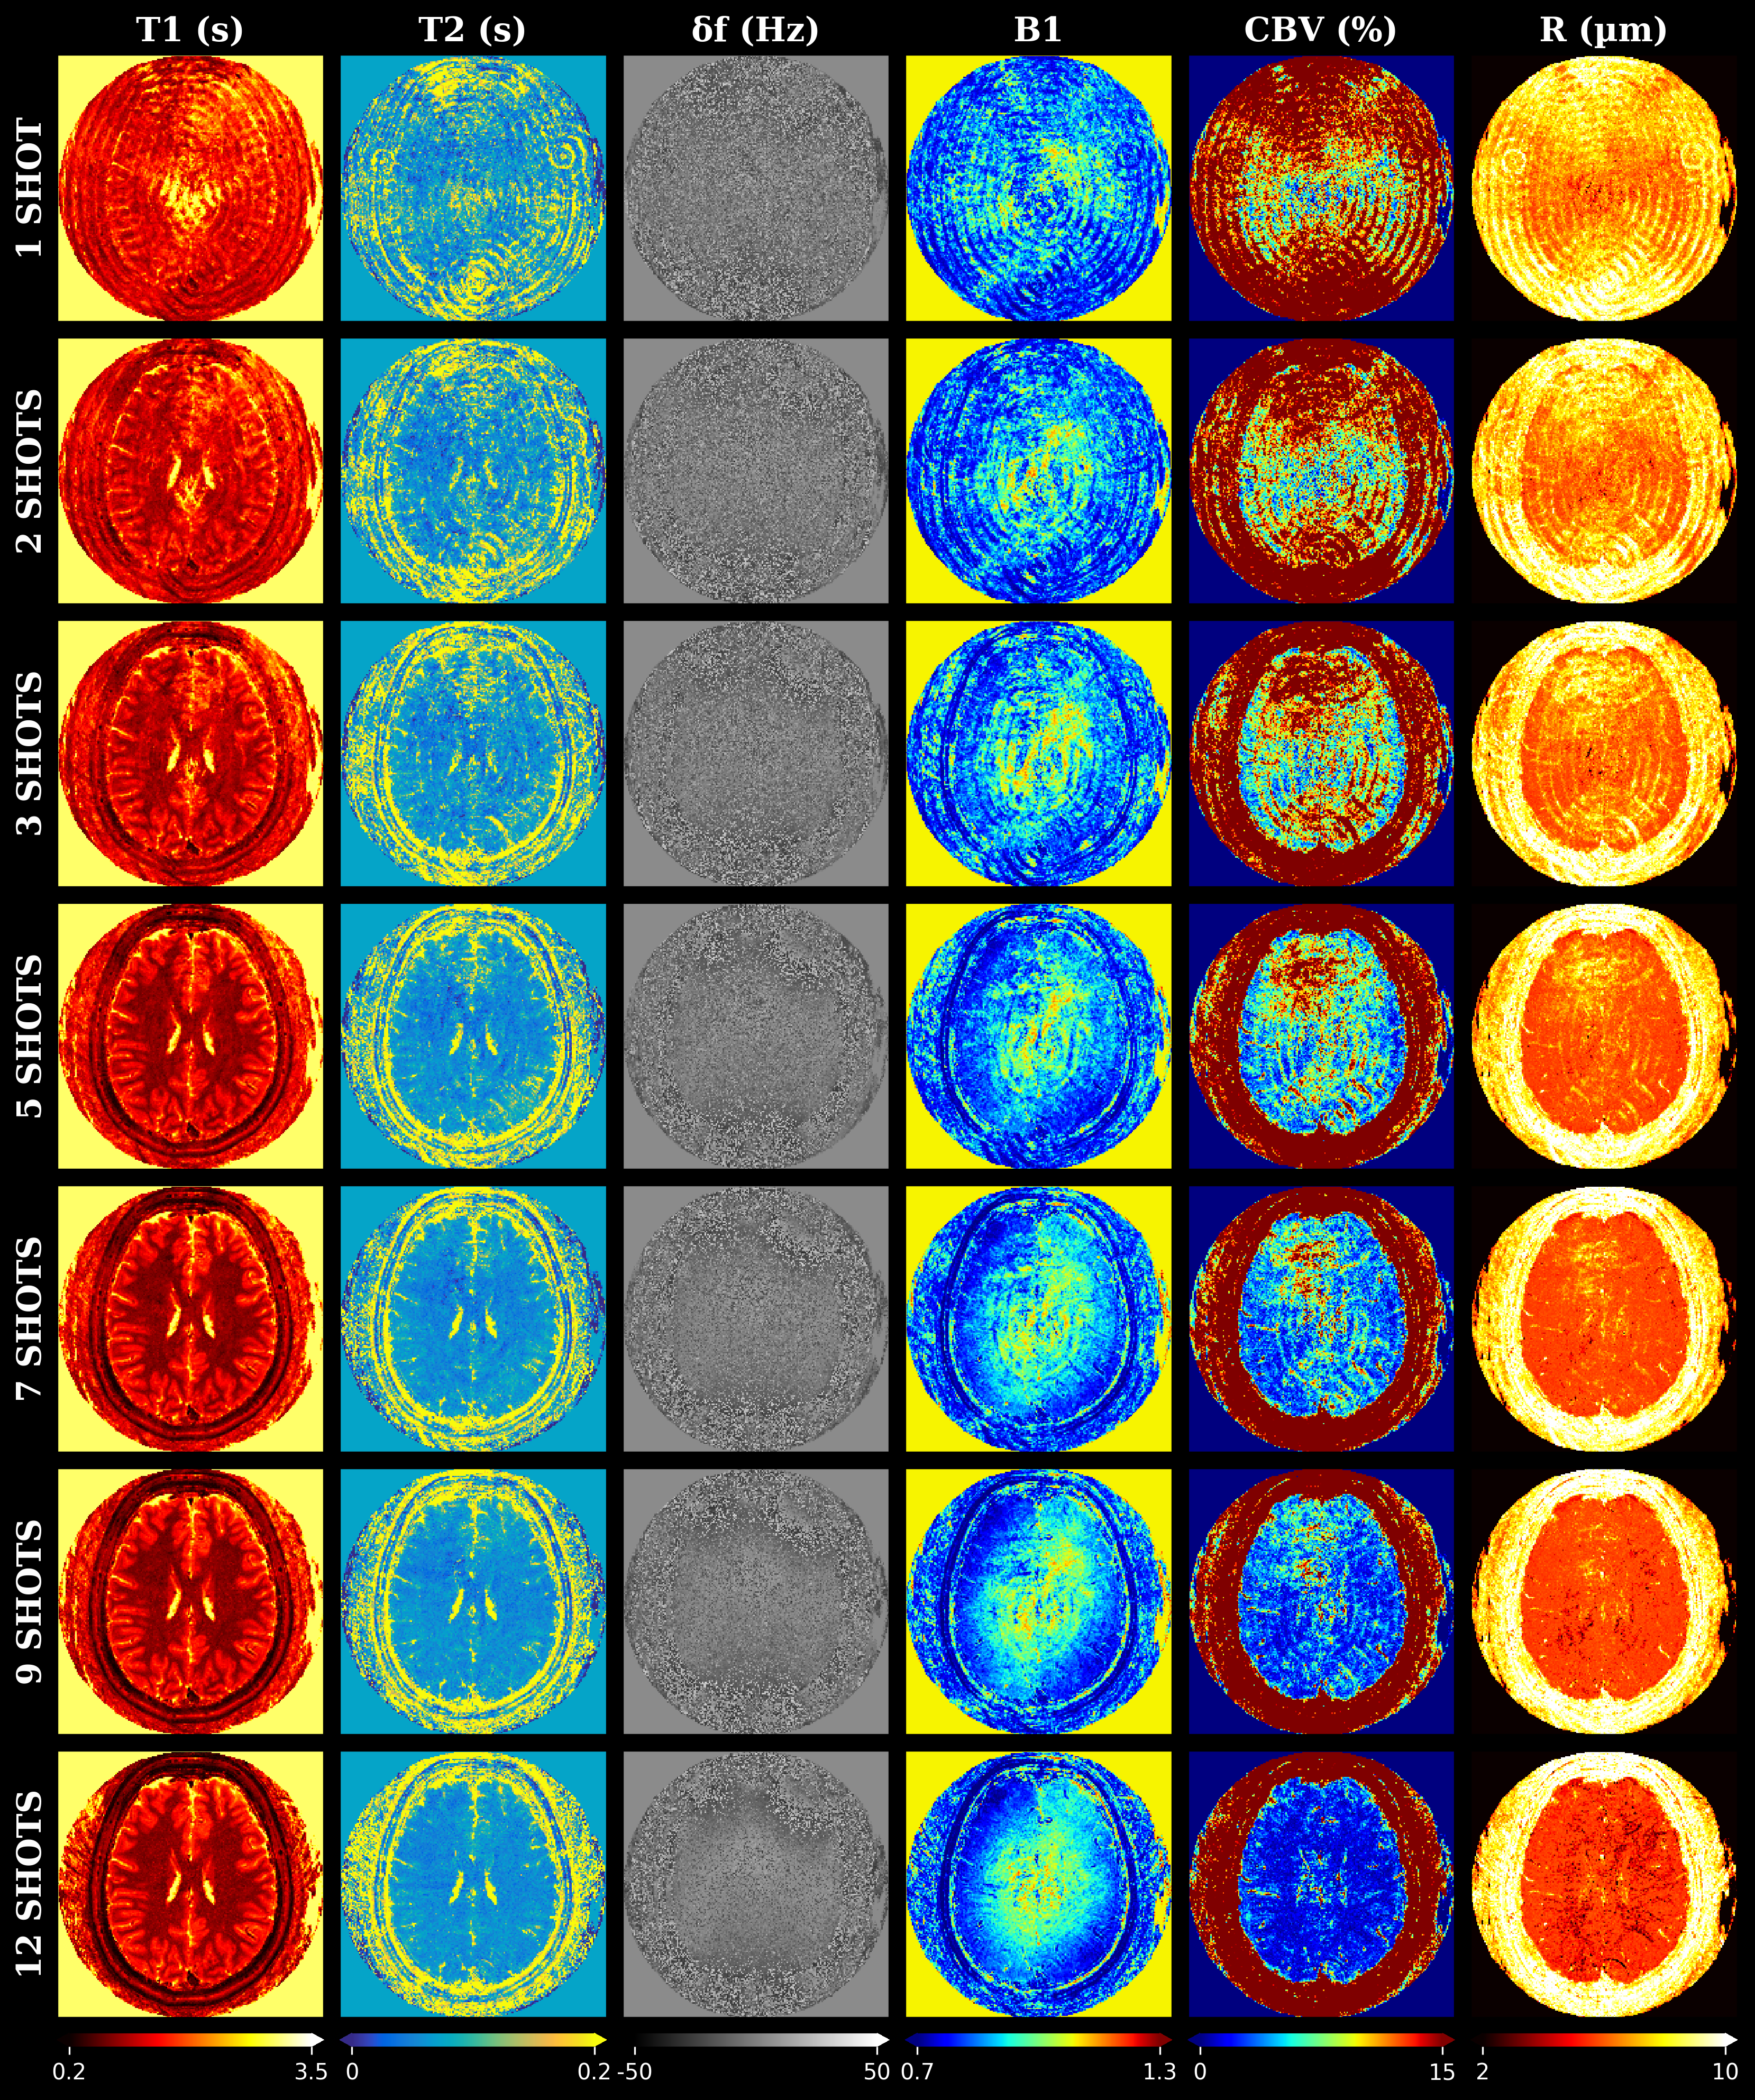

In [ ]:
reconstruction_us = NN_prediction_complex(NN, RECO_mask_normalized, label_parameters, batch_size=1024)
fig = plot_parameter_maps(reconstruction_us, learned_labels, crop_type='separate', title='')
